In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [45]:
class DecisionTreeRegressor:
    """
    Decision Tree Regressor.

    Attributes:
        max_depth (int): The maximum depth of the tree.
    """
    def __init__(self, max_depth=None):
        """
        Initializes the DecisionTreeRegressor.

        Args:
            max_depth (int, optional): The maximum depth of the tree. Defaults to None (unlimited depth).
        """
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        """
        Builds the decision tree from the training data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
        """
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        """
        Predicts the output for the given data.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).

        Returns:
            ndarray: The predicted values, shape (n_samples,).
        """
        predictions = [self._predict_one(x, self.tree) for x in X]
        return np.array(predictions)

    def _build_tree(self, X, y, depth):
        """
        Recursively builds the decision tree.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).
            depth (int): The current depth of the tree.

        Returns:
            dict: A dictionary representing the decision tree node.
        """
        n_samples, n_features = X.shape

        # Base cases:
        # 1. If there are no more samples, return the mean of the target values.
        if n_samples == 0:
            return {'value': np.mean(y)}
        # 2. If all target values are the same, return that value.
        if np.all(y == y[0]):
            return {'value': y[0]}
        # 3. If the maximum depth is reached, return the mean of the target values.
        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': np.mean(y)}
        # 4. If there are no more features to split on
        if n_features == 0:
            return {'value': np.mean(y)}

        # Try to find the best possible feature and threshold to split on
        best_split = self._get_best_split(X, y)

        # If no good split is found, return the mean of the target values
        if best_split['feature_index'] is None:
            return {'value': np.mean(y)}

        # Split data and recursively build left and right subtrees
        left_X, left_y = best_split['left_X'], best_split['left_y']
        right_X, right_y = best_split['right_X'], best_split['right_y']

        left_child = self._build_tree(left_X, left_y, depth + 1)
        right_child = self._build_tree(right_X, right_y, depth + 1)

        # Return the node
        return {
            'feature_index': best_split['feature_index'],
            'threshold': best_split['threshold'],
            'left_child': left_child,
            'right_child': right_child,
        }

    def _get_best_split(self, X, y):
        """
        Finds the best split for the data based on the variance reduction.

        Args:
            X (ndarray): The input features, shape (n_samples, n_features).
            y (ndarray): The target values, shape (n_samples,).

        Returns:
            dict: A dictionary containing the best split information.
                {'feature_index': int, 'threshold': float, 'left_X': ndarray, 'left_y': ndarray,
                 'right_X': ndarray, 'right_y': ndarray}
        """
        n_samples, n_features = X.shape
        if n_features == 0:
            return {}

        # Calculate the initial variance
        initial_variance = np.var(y)
        best_variance_reduction = 0
        best_split = {}

        for feature_index in range(n_features):
            # Get the unique values of the feature
            feature_values = np.unique(X[:, feature_index])
            #consider all values as thresholds
            for threshold in feature_values:
                # Split the data based on the threshold
                left_mask = X[:, feature_index] <= threshold
                right_mask = X[:, feature_index] > threshold
                left_X, left_y = X[left_mask], y[left_mask]
                right_X, right_y = X[right_mask], y[right_mask]

                # Calculate the variance reduction
                if len(left_y) > 0 and len(right_y) > 0:
                    left_variance = np.var(left_y)
                    right_variance = np.var(right_y)
                    variance_reduction = initial_variance - (len(left_y) / n_samples) * left_variance - (
                        len(right_y) / n_samples
                    ) * right_variance

                    # Update the best split if it's better than the current best
                    if variance_reduction > best_variance_reduction:
                        best_variance_reduction = variance_reduction
                        best_split = {
                            'feature_index': feature_index,
                            'threshold': threshold,
                            'left_X': left_X,
                            'left_y': left_y,
                            'right_X': right_X,
                            'right_y': right_y,
                        }

        return best_split

    def _predict_one(self, x, node):
        """
        Predicts the output for a single data point using the decision tree.

        Args:
            x (ndarray): A single data point with shape (n_features,).
            node (dict): A dictionary representing a decision tree node.

        Returns:
            float: The predicted value.
        """
        # If the node is a leaf node, return the value
        if 'value' in node:
            return node['value']

        # Otherwise, go to the left or right child based on the feature value
        if x[node['feature_index']] <= node['threshold']:
            return self._predict_one(x, node['left_child'])
        else:
            return self._predict_one(x, node['right_child'])
        
    def score(self, X, y):
        """
        Calculates the coefficient of determination (R^2) of the prediction.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).
            y (ndarray): True target values, shape (n_samples,).

        Returns:
            float: R^2 score.
        """
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else 0

In [47]:
df = pd.read_csv("cleaned_mlb_2022_full.csv")

# Select features and target
features = ['Barrel%', 'EV', 'LA', 'BB%', 'K%', 'Contact%', 'Swing%', 'O-Swing%']
target = 'WAR'

X = df[features].values
y = df[target].values

# Normalize features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

In [49]:
# Initialize and train
tree = DecisionTreeRegressor(max_depth=4)
tree.fit(X_train, y_train)

# Predict on test set
y_pred = tree.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 2.36
MAE: 1.98
R² Score: -0.56


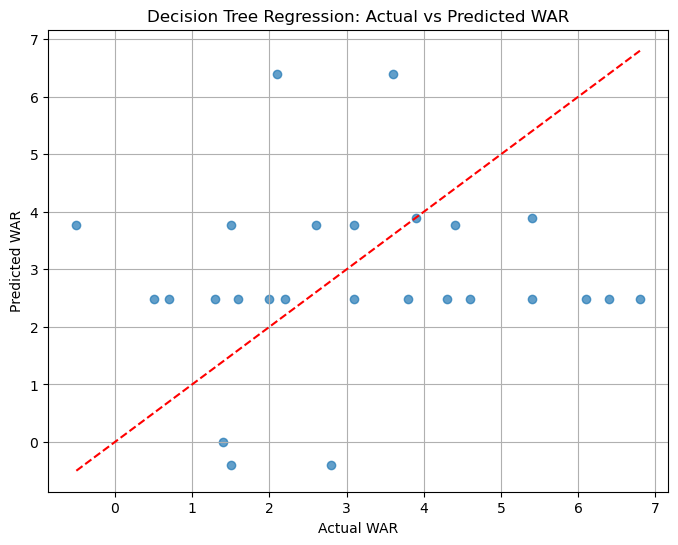

In [37]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual WAR")
plt.ylabel("Predicted WAR")
plt.title("Decision Tree Regression: Actual vs Predicted WAR")
plt.grid(True)
plt.show()

This scatterplot compares actual WAR values to the predictions generated by our custom decision tree model. Ideally, points would align along the red diagonal line, which represents perfect prediction. However, we see that the model frequently predicts flat or repeated values, a hallmark of decision tree outputs due to hard splits and limited granularity. The predictions often cluster around a few horizontal bands, especially between 2 and 4 WAR, and fail to fully capture the range of actual player performance — particularly for both replacement-level players and top-tier stars. This reflects a limitation in how well the tree partitions continuous output space with a shallow depth.

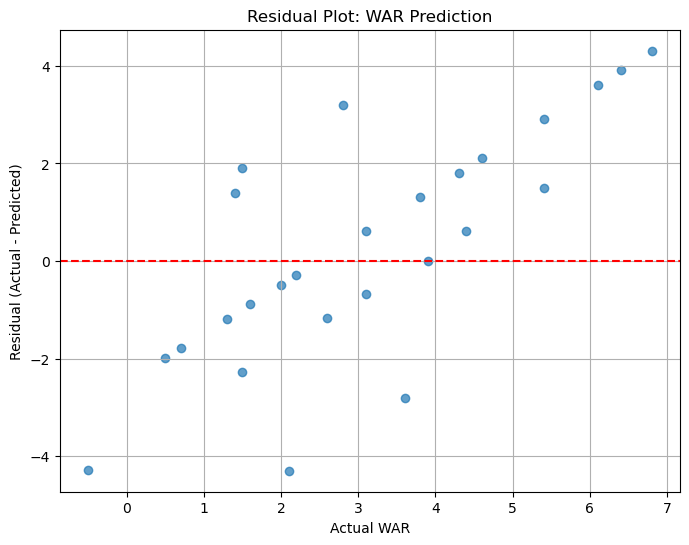

In [39]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual WAR")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot: WAR Prediction")
plt.grid(True)
plt.show()

This residual plot visualizes prediction errors (Actual − Predicted) across the range of actual WAR values. A perfect model would have residuals centered randomly around 0 with no visible trend. Instead, we observe a clear pattern: players with lower actual WAR are overpredicted (negative residuals), while players with higher WAR are underpredicted (positive residuals). This “regression toward the mean” is common in trees with shallow depth or poor variance reduction, as the model tends to gravitate toward average outcomes and fails to represent outliers. The systematic nature of these errors suggests the model is not flexible enough to distinguish high-value contributors from league-average players.

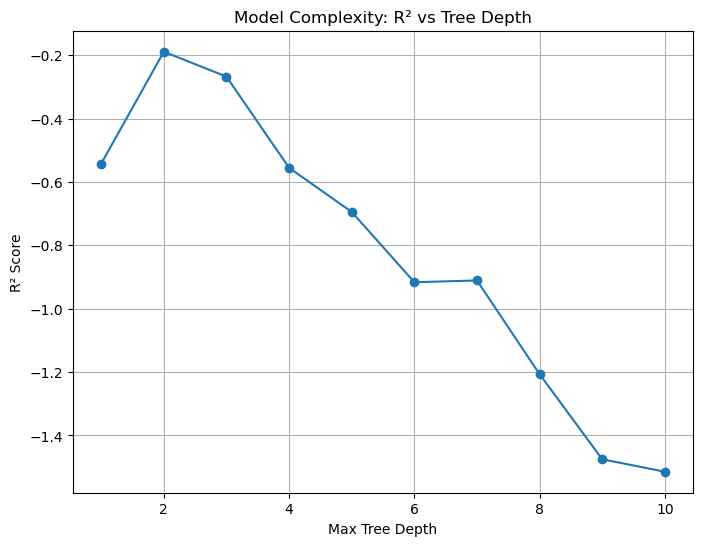

In [41]:
depths = range(1, 11)
r2_scores = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, pred))

plt.figure(figsize=(8, 6))
plt.plot(depths, r2_scores, marker='o')
plt.xlabel("Max Tree Depth")
plt.ylabel("R² Score")
plt.title("Model Complexity: R² vs Tree Depth")
plt.grid(True)
plt.show()

This plot tracks the model's R² performance across increasing tree depths. Interestingly, we see that performance peaks around depth 2–3 before steadily deteriorating. This suggests overfitting at deeper levels: the model memorizes training splits without improving generalization. The negative R² scores confirm that deeper trees perform worse than simply predicting the mean, which reinforces that our feature set may not have strong enough predictive power to justify deeper branching. This plot serves as a reminder that for decision trees, increasing complexity doesn’t guarantee better fit — especially when the input features lack highly discriminative splits.

Using a custom decision tree regressor to predict WAR from Statcast-style features yielded limited success. The model produced an RMSE of 2.36 and an MAE of 1.98, with an R² score of –0.56, meaning it performed worse than simply predicting the average WAR. The actual vs. predicted plot showed clustering around a few repeated values, while the residual plot revealed a clear bias toward underpredicting top performers and overpredicting weaker ones. Even increasing the tree depth failed to improve generalization, with R² scores deteriorating rapidly due to overfitting. These results suggest that while decision trees can capture basic structure, WAR is likely too complex to model accurately using only batted-ball and plate discipline inputs — especially with limited tree depth and no ensemble strategy.